In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from datetime import datetime
from collections import Counter
import re
from sklearn.preprocessing import LabelEncoder

In [2]:
data = pd.read_csv('expedia_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62774 entries, 0 to 62773
Data columns (total 34 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   name                                62774 non-null  object 
 1   current_price                       62774 non-null  float64
 2   reviews_desc                        62774 non-null  int64  
 3   num_reviews                         62774 non-null  float64
 4   breakfast                           62774 non-null  int64  
 5   free_cancellation                   62774 non-null  int64  
 6   grade                               62774 non-null  float64
 7   fully_refundable                    62774 non-null  int64  
 8   reserve_now_pay_later               62774 non-null  int64  
 9   price_after_taxes                   62774 non-null  float64
 10  checkin_date                        62774 non-null  object 
 11  checkout_date                       62774

In [3]:
# Adding features using existing variables

# Handling the hotel name field
# Creating a LabelEncoder object
label_encoder = LabelEncoder()
# Convert names to numeric identifiers
data['hotel_id'] = label_encoder.fit_transform(data['name'])

def convert_to_date(date_str):
    return datetime.strptime(date_str, '%Y-%m-%d')

data['checkin_date'] = data['checkin_date'].apply(convert_to_date)
#data['checkin_day'] = data['checkin_date'].dt.day

# Adding a feature for the day of the week based on the check-in date
def get_day_of_week(date_obj):
    # Get the day of the week number (0 - Sunday, 1 - Monday, and so on)
    day_of_week = date_obj.weekday()
    return day_of_week

# Replace the values ​​in the 'bed_type' column with the new classification values
data['checkin_day_week'] = data['checkin_date'].apply(get_day_of_week)

In [4]:
def add_all_services_column(data):
    # Define a condition that checks if all services are offered by the hotel
    conditions = (data['reserve_now_pay_later'] == 1) & \
                 (data['fully_refundable'] == 1) & \
                 (data['free_cancellation'] == 1) & \
                 (data['breakfast'] == 1)
    
    # Add the new column with a result of 1 if all conditions are met, otherwise 0
    data['all_services'] = conditions.astype(int)
    return data

data = add_all_services_column(data)

data.head()
value_counts = data['all_services'].value_counts()
value_counts

all_services
0    59943
1     2831
Name: count, dtype: int64

Correlations with price:
price               1.000000
hotel_id            0.070692
all_services        0.019982
checkin_day_week   -0.051968
Name: price, dtype: float64


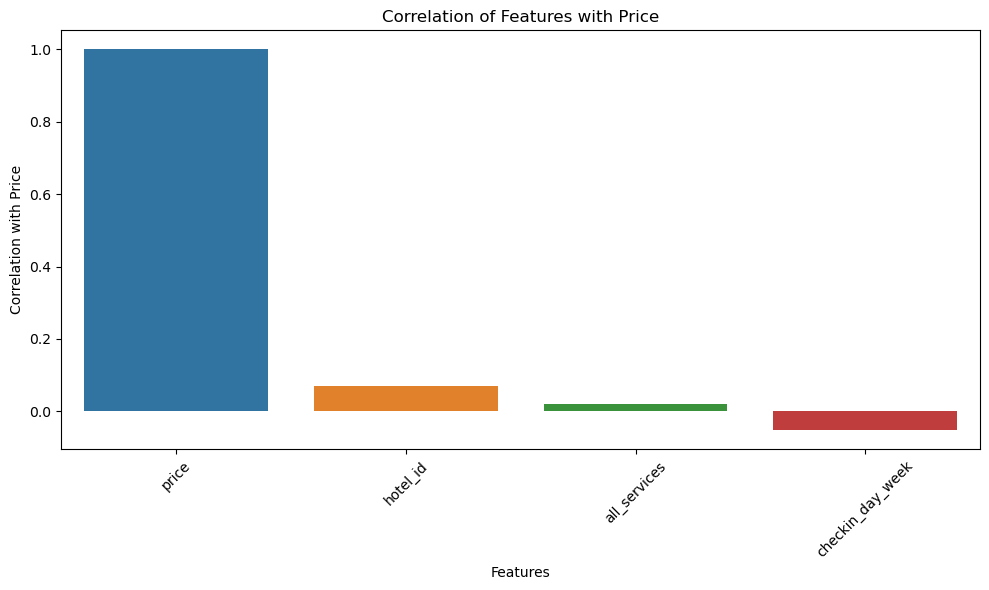

In [5]:
price_correlations = data[['price','all_services', 'checkin_day_week', 'hotel_id']].corr()['price'].sort_values(ascending=False)

print("Correlations with price:")
print(price_correlations)

plt.figure(figsize=(10, 6))
sns.barplot(x=price_correlations.index, y=price_correlations.values)
plt.title('Correlation of Features with Price')
plt.xlabel('Features')
plt.ylabel('Correlation with Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [6]:
data = data.drop(['name', 'checkin_date' ,'checkout_date', 'Snapshot Date','current_price','price_after_taxes'], axis=1)
data_wo_features = data.drop([ 'checkin_day_week', 'all_services','hotel_id'], axis=1)

In [7]:
data.describe()

reviews_desc   num_reviews     breakfast  free_cancellation  \
count  62774.000000  62774.000000  62774.000000       62774.000000   
mean       2.946188   1465.367588      0.130420           0.468283   
std        1.110829   1022.960264      0.336768           0.498997   
min        1.000000      1.000000      0.000000           0.000000   
25%        2.000000   1002.000000      0.000000           0.000000   
50%        3.000000   1060.000000      0.000000           0.000000   
75%        4.000000   1651.000000      0.000000           1.000000   
max        5.000000   5946.000000      1.000000           1.000000   

              grade  fully_refundable  reserve_now_pay_later           TTT  \
count  62774.000000      62774.000000           62774.000000  62774.000000   
mean       8.694572          0.468283               0.348504     15.206630   
std        0.576195          0.498997               0.476500      8.652064   
min        7.070000          0.000000               0.000000      0.000000   
25%        8.280000          0.000000               0.000000      8.000000   
50%        8.880000          0.000000               0.000000     15.000000   
75%        9.090000          1.000000               1.000000     23.000000   
max        9.890000          1.000000               1.000000     30.000000   

                LOS         order         price      hotel_id  \
count  62774.000000  62774.000000  62774.000000  62774.000000   
mean       2.977347     78.119970   3434.343422    208.572865   
std        1.408512     43.797325   2835.527222    125.403943   
min        1.000000      2.000000    128.000000      0.000000   
25%        2.000000     40.000000   1036.000000    107.000000   
50%        3.000000     78.000000   2685.000000    194.000000   
75%        4.000000    117.000000   5504.000000    308.000000   
max        5.000000    155.000000  12460.000000    432.000000   

       checkin_day_week  all_services  
count      62774.000000  62774.000000  
mean           3.059563      0.045098  
std            2.040696      0.207521  
min            0.000000      0.000000  
25%            1.000000      0.000000  
50%            3.000000      0.000000  
75%            5.000000      0.000000  
max            6.000000      1.000000

In [8]:
data_wo_features.describe()

reviews_desc   num_reviews     breakfast  free_cancellation  \
count  62774.000000  62774.000000  62774.000000       62774.000000   
mean       2.946188   1465.367588      0.130420           0.468283   
std        1.110829   1022.960264      0.336768           0.498997   
min        1.000000      1.000000      0.000000           0.000000   
25%        2.000000   1002.000000      0.000000           0.000000   
50%        3.000000   1060.000000      0.000000           0.000000   
75%        4.000000   1651.000000      0.000000           1.000000   
max        5.000000   5946.000000      1.000000           1.000000   

              grade  fully_refundable  reserve_now_pay_later           TTT  \
count  62774.000000      62774.000000           62774.000000  62774.000000   
mean       8.694572          0.468283               0.348504     15.206630   
std        0.576195          0.498997               0.476500      8.652064   
min        7.070000          0.000000               0.000000      0.000000   
25%        8.280000          0.000000               0.000000      8.000000   
50%        8.880000          0.000000               0.000000     15.000000   
75%        9.090000          1.000000               1.000000     23.000000   
max        9.890000          1.000000               1.000000     30.000000   

                LOS         order         price  
count  62774.000000  62774.000000  62774.000000  
mean       2.977347     78.119970   3434.343422  
std        1.408512     43.797325   2835.527222  
min        1.000000      2.000000    128.000000  
25%        2.000000     40.000000   1036.000000  
50%        3.000000     78.000000   2685.000000  
75%        4.000000    117.000000   5504.000000  
max        5.000000    155.000000  12460.000000

In [9]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# From the above, it can be seen that the data ranges for the "Number of Reviews"
# variable and the "Distance from Center" variable are different from the rest, 
# so we will normalize them.
columns_to_normalize = [ 'num_reviews']

# Min-Max Scaling
min_max_scaler = MinMaxScaler()
data_min_max_scaled = data.copy()
data_min_max_scaled[columns_to_normalize] = min_max_scaler.fit_transform(data[columns_to_normalize])

# Standardization
standard_scaler = StandardScaler()
data_standard_scaled = data.copy()
data_standard_scaled[columns_to_normalize] = standard_scaler.fit_transform(data[columns_to_normalize])

print("Original Data:")
print(data[columns_to_normalize].head())

print("\nMin-Max Scaled Data:")
print(data_min_max_scaled[columns_to_normalize].head())

print("\nStandard Scaled Data:")
print(data_standard_scaled[columns_to_normalize].head())

Original Data:
   num_reviews
0       1306.0
1       3670.0
2        521.0
3       2625.0
4       3586.0

Min-Max Scaled Data:
   num_reviews
0     0.219512
1     0.617157
2     0.087468
3     0.441379
4     0.603028

Standard Scaled Data:
   num_reviews
0    -0.155792
1     2.155167
2    -0.923179
3     1.133614
4     2.073051


In [10]:
data_wo_features = data_min_max_scaled.drop([ 'checkin_day_week','hotel_id','all_services'], axis=1)

DataFrame: data



C:\Users\ygastfraind\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\ygastfraind\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\ygastfraind\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\ygastfraind\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\ygastfraind\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Test Set Results:
   n_estimators  Mean Squared Error  Root Mean Squared Error  \
0            10        7.184844e+05               847.634614   
1            50        9.449403e+05               972.080398   
2           100        1.173085e+06              1083.090606   
3           200        1.331756e+06              1154.017427   
4           500        1.399089e+06              1182.830868   

   Mean Absolute Error       R^2  
0           565.229546  0.909058  
1           746.868834  0.880394  
2           901.423719  0.851517  
3           982.177480  0.831433  
4          1011.169120  0.822910  
Train Set Results:
   n_estimators  Mean Squared Error  Root Mean Squared Error  \
0            10        7.263270e+05               852.248176   
1            50        9.477402e+05               973.519466   
2           100        1.175673e+06              1084.284660   
3           200        1.327678e+06              1152.249096   
4           500        1.393503e+06             

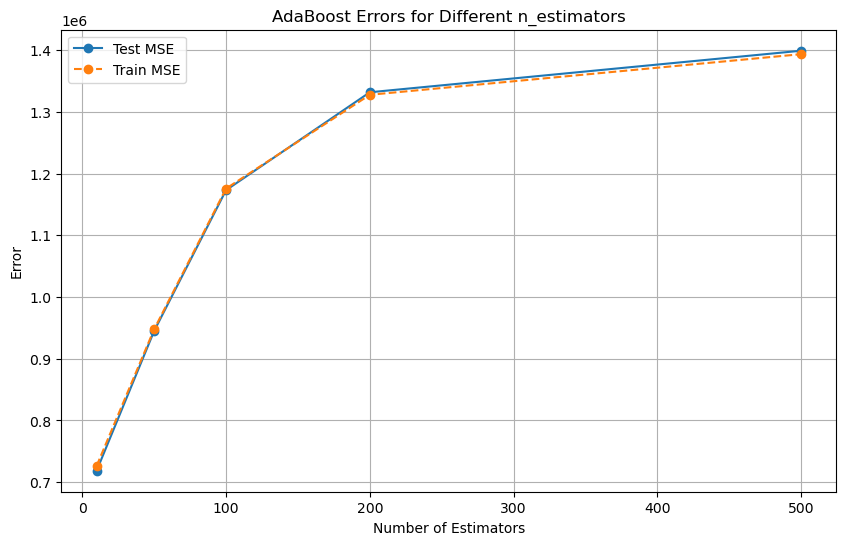

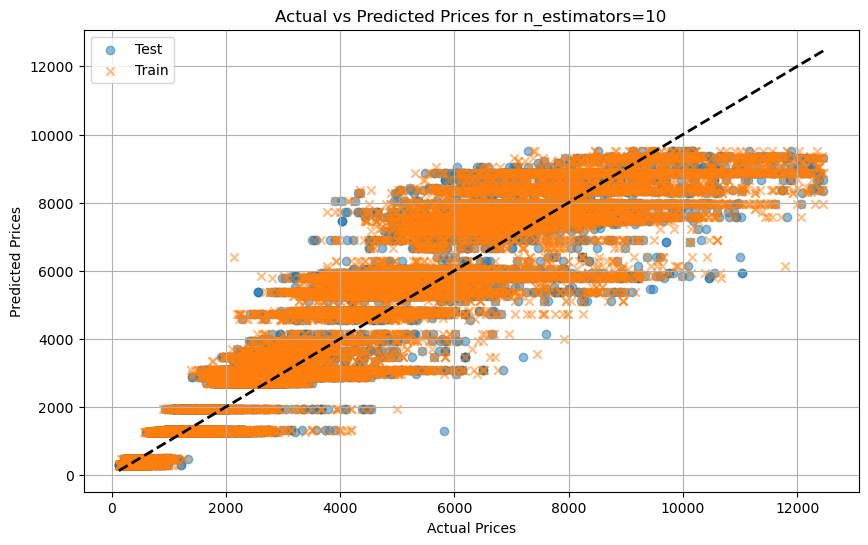

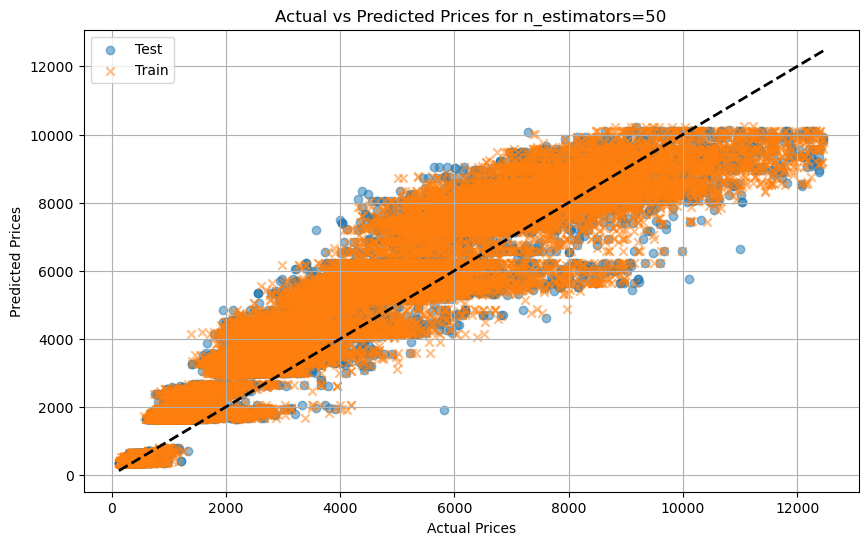

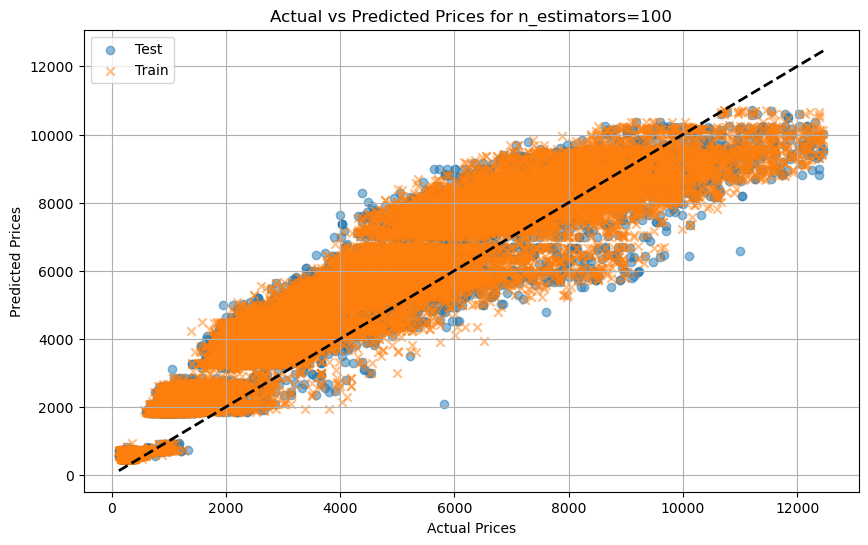

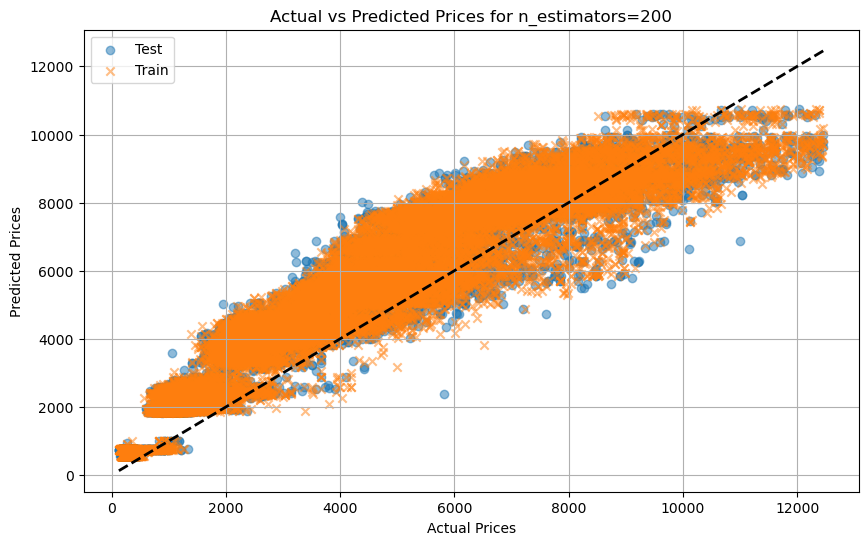

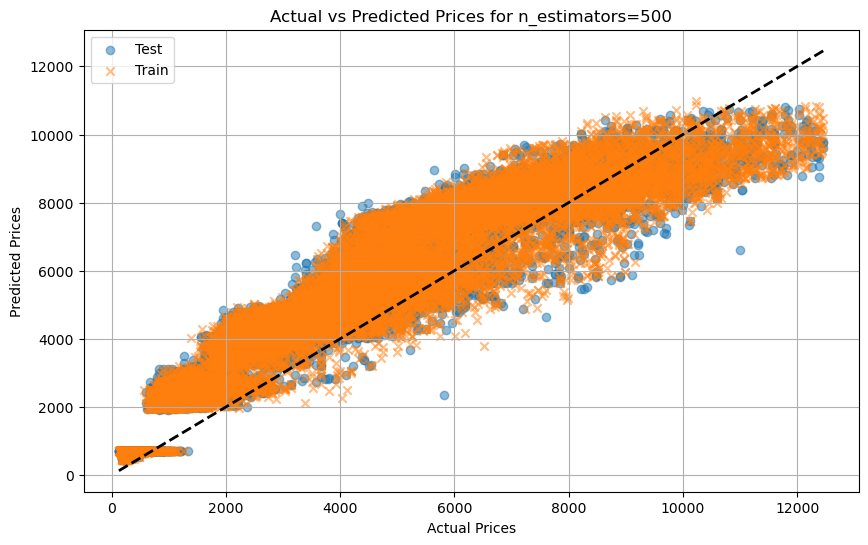

<Figure size 1000x600 with 0 Axes>

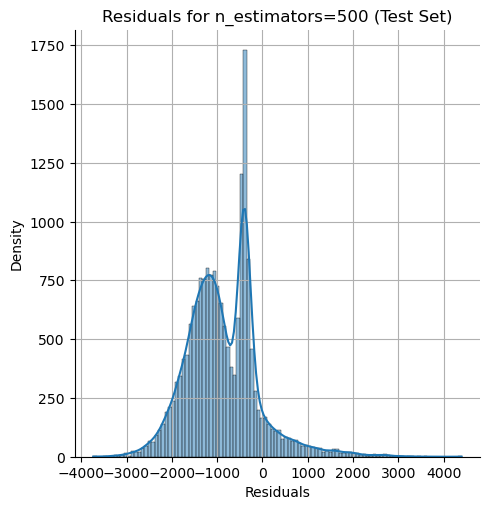

<Figure size 1000x600 with 0 Axes>

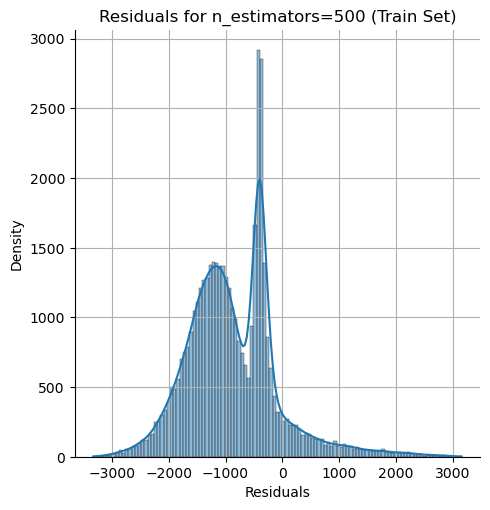

DataFrame: data_min_max_scaled



C:\Users\ygastfraind\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\ygastfraind\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\ygastfraind\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\ygastfraind\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\ygastfraind\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Test Set Results:
   n_estimators  Mean Squared Error  Root Mean Squared Error  \
0            10        7.379165e+05               859.020655   
1            50        9.290619e+05               963.878546   
2           100        1.144182e+06              1069.664206   
3           200        1.235137e+06              1111.367208   
4           500        1.128442e+06              1062.281717   

   Mean Absolute Error       R^2  
0           578.267938  0.908493  
1           745.089978  0.884789  
2           890.913584  0.858113  
3           944.661307  0.846834  
4           887.850370  0.860065  
Train Set Results:
   n_estimators  Mean Squared Error  Root Mean Squared Error  \
0            10        7.160804e+05               846.215322   
1            50        9.116823e+05               954.820578   
2           100        1.136489e+06              1066.062238   
3           200        1.230611e+06              1109.329242   
4           500        1.120858e+06             

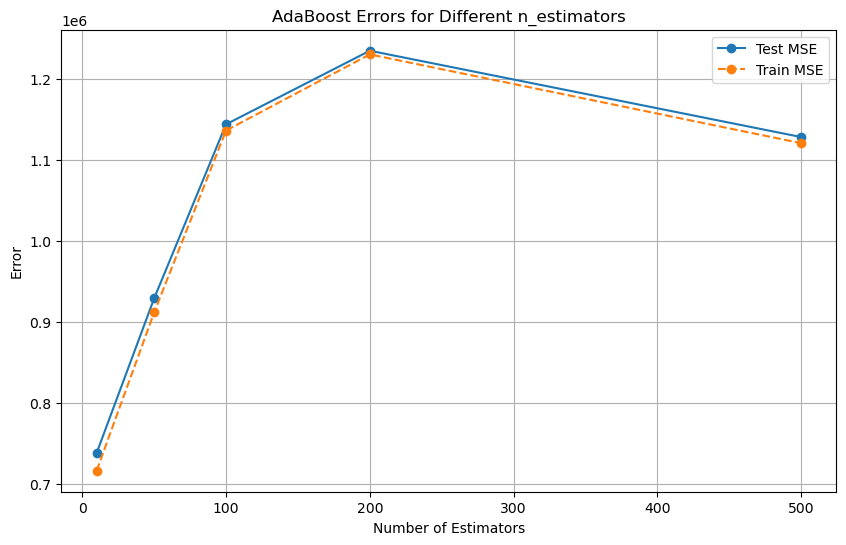

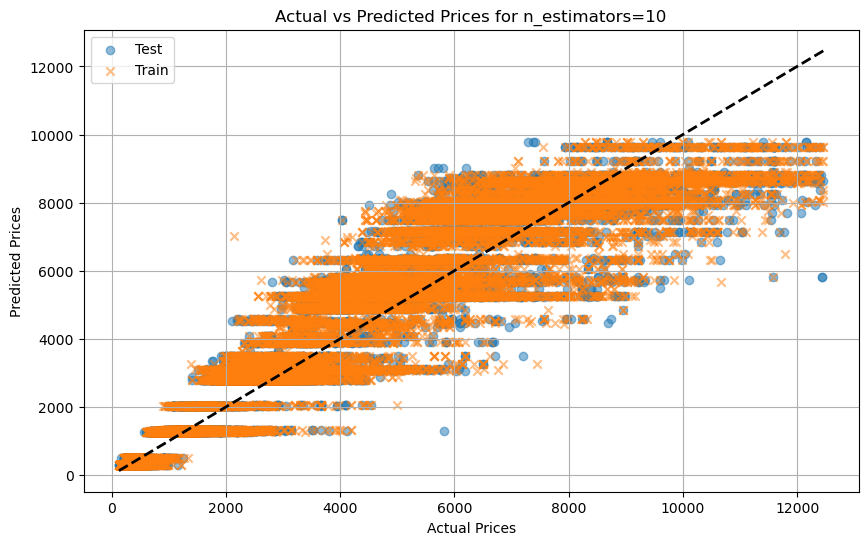

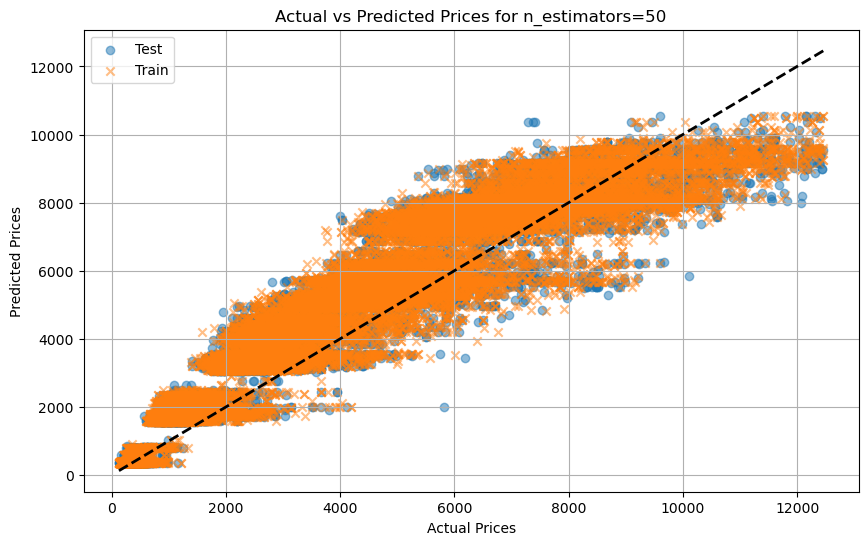

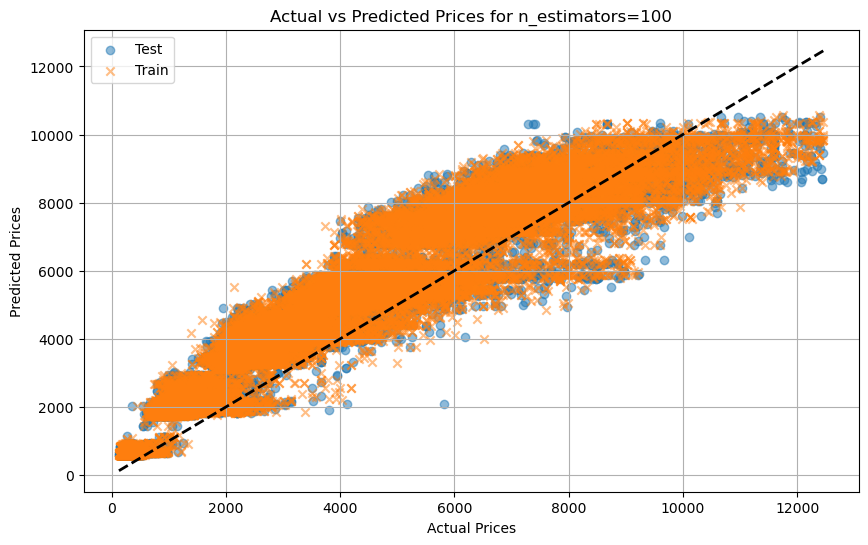

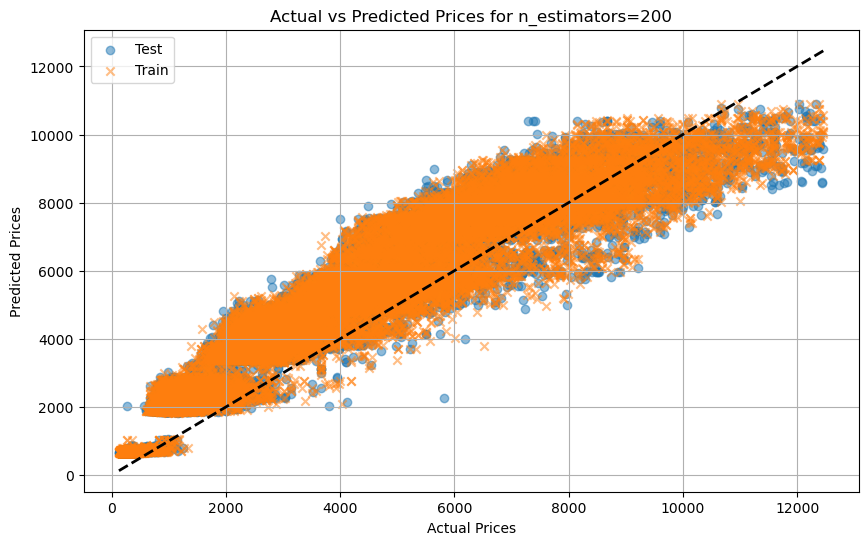

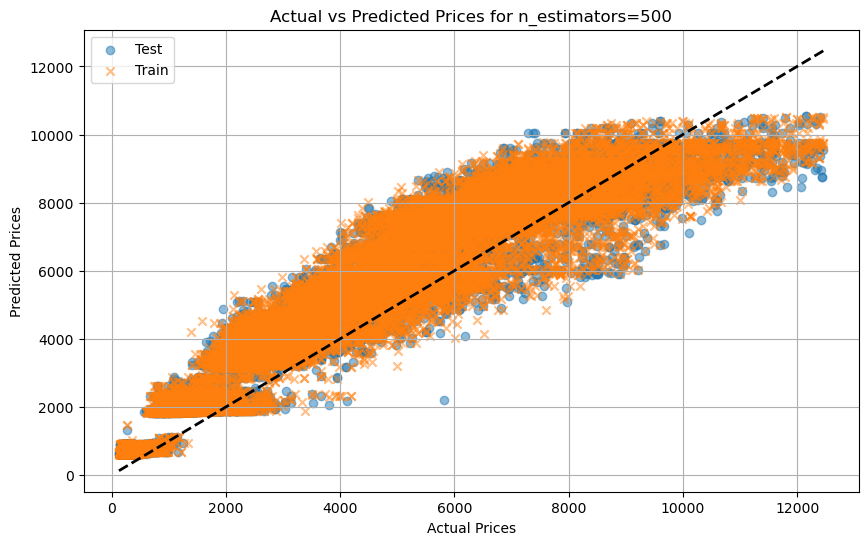

<Figure size 1000x600 with 0 Axes>

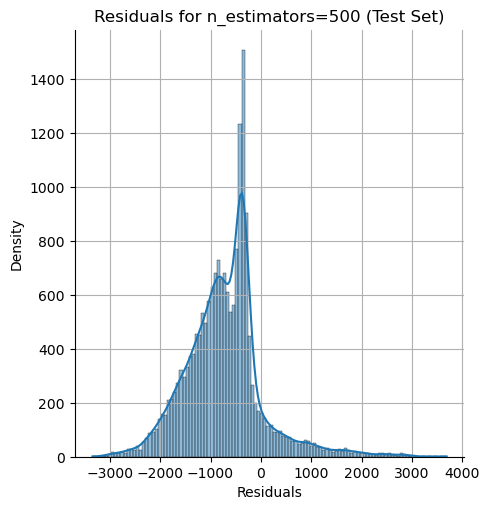

<Figure size 1000x600 with 0 Axes>

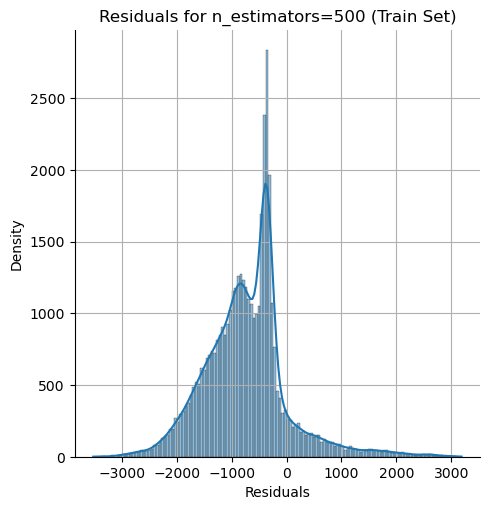

DataFrame: data_wo_features



C:\Users\ygastfraind\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\ygastfraind\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\ygastfraind\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\ygastfraind\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\ygastfraind\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Test Set Results:
   n_estimators  Mean Squared Error  Root Mean Squared Error  \
0            10        8.083186e+05               899.065412   
1            50        1.005517e+06              1002.754819   
2           100        1.359484e+06              1165.969258   
3           200        1.470470e+06              1212.629316   
4           500        1.596541e+06              1263.542918   

   Mean Absolute Error       R^2  
0           607.210517  0.899387  
1           743.976718  0.874841  
2           953.006602  0.830782  
3          1011.892662  0.816967  
4          1061.985606  0.801275  
Train Set Results:
   n_estimators  Mean Squared Error  Root Mean Squared Error  \
0            10        7.922750e+05               890.098318   
1            50        9.849528e+05               992.447881   
2           100        1.336275e+06              1155.973638   
3           200        1.449466e+06              1203.937910   
4           500        1.567859e+06             

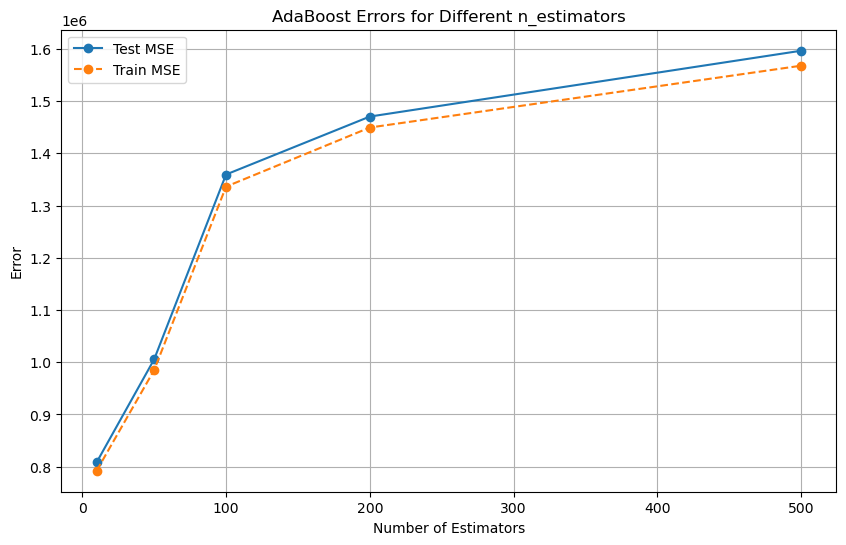

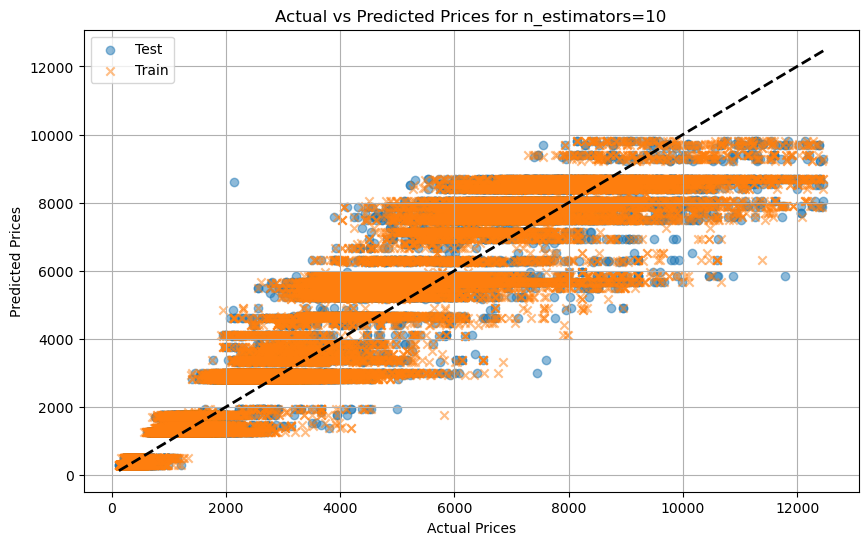

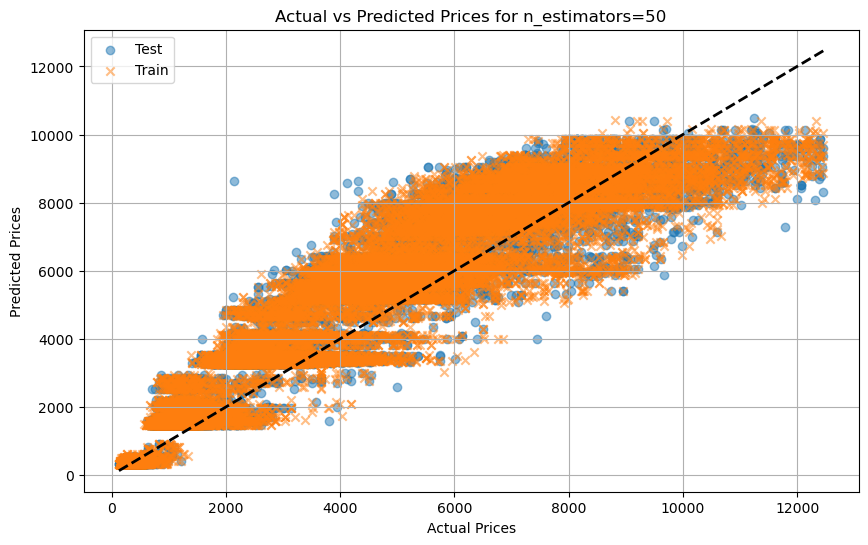

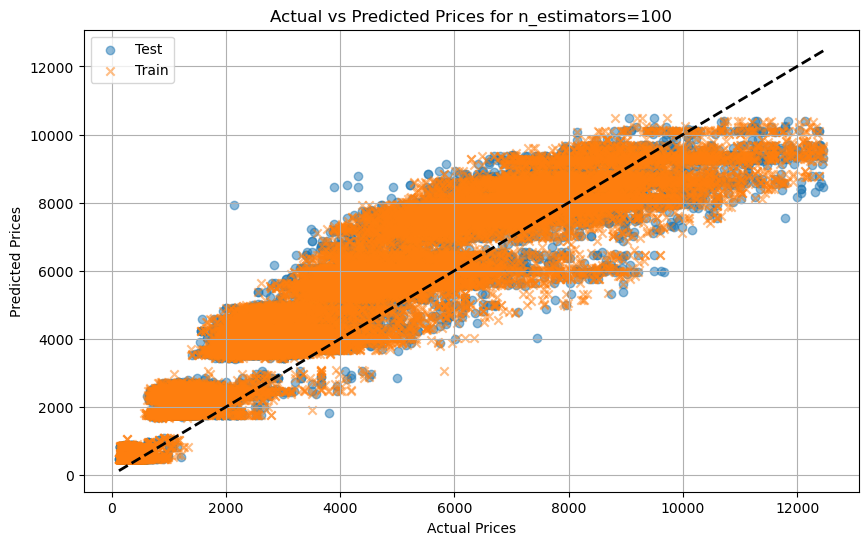

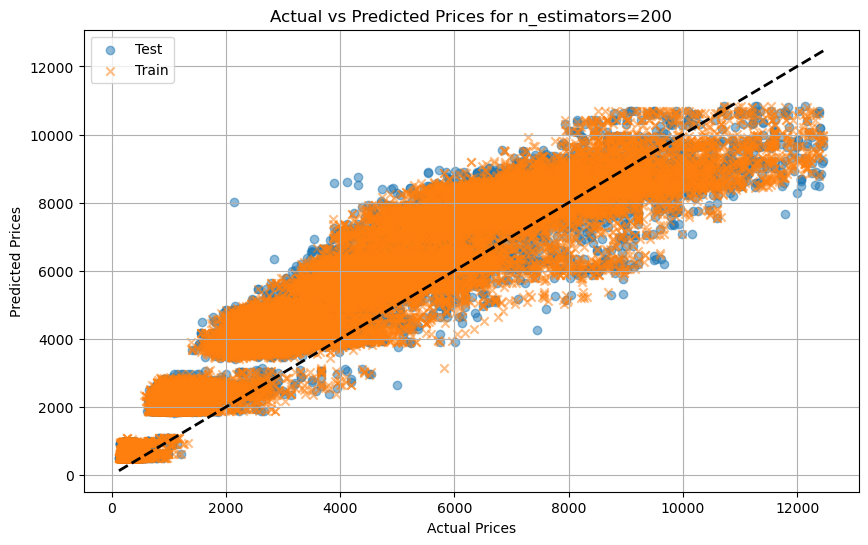

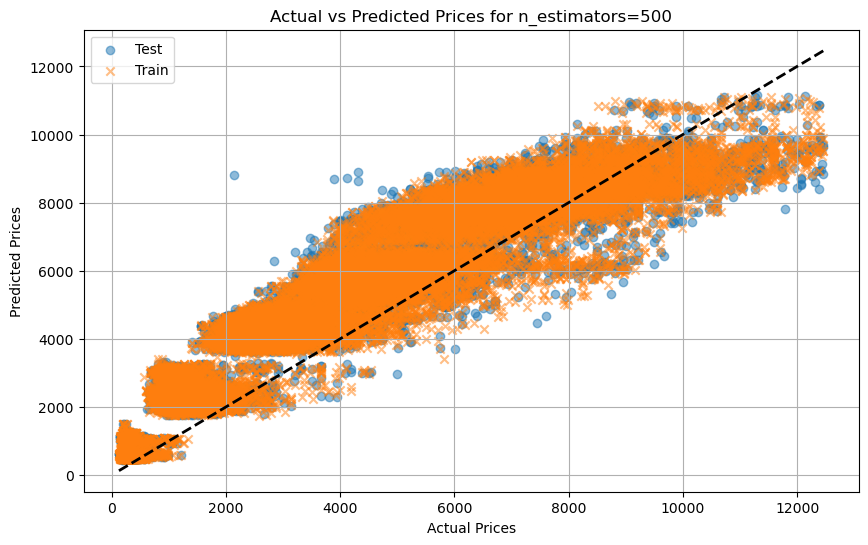

<Figure size 1000x600 with 0 Axes>

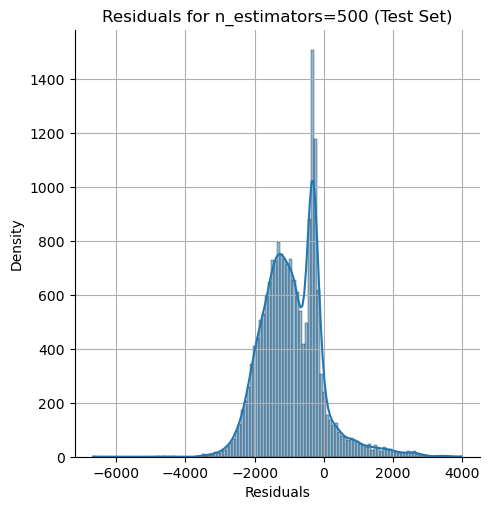

<Figure size 1000x600 with 0 Axes>

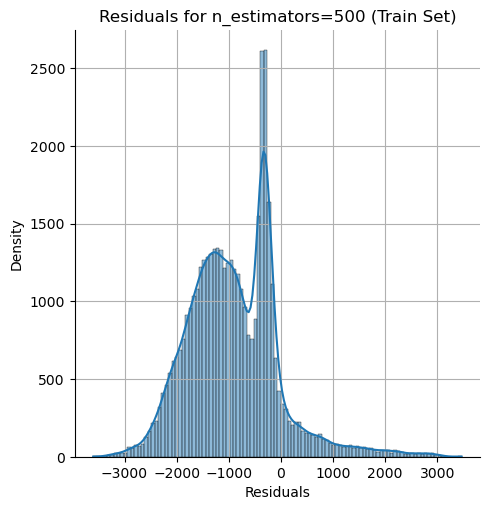

In [11]:
data_types = [data, data_min_max_scaled, data_wo_features]

for df in data_types:
    df_name = next(key for key, value in locals().items() if value is df)
    print(f"DataFrame: {df_name}")
    print()
    
    X = df.drop('price', axis=1)
    y = df['price']

    # Split the data into training and test sets (70% train, 30% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    # Define the function to evaluate AdaBoost
    def evaluate_adaboost(n_estimators_list, X_train, y_train, X_test, y_test):
        results = {}
        for n_estimators in n_estimators_list:
            adaboost = AdaBoostRegressor(
                base_estimator=DecisionTreeRegressor(max_depth=4),
                n_estimators=n_estimators
            )
            adaboost.fit(X_train, y_train)
            
            # Evaluate on test set
            y_pred_test = adaboost.predict(X_test)
            mse_test = mean_squared_error(y_test, y_pred_test)
            rmse_test = np.sqrt(mse_test)
            mae_test = mean_absolute_error(y_test, y_pred_test)
            r2_test = r2_score(y_test, y_pred_test)
            
            # Evaluate on train set
            y_pred_train = adaboost.predict(X_train)
            mse_train = mean_squared_error(y_train, y_pred_train)
            rmse_train = np.sqrt(mse_train)
            mae_train = mean_absolute_error(y_train, y_pred_train)
            r2_train = r2_score(y_train, y_pred_train)
            
            results[n_estimators] = {
                'test': {'mse': mse_test, 'rmse': rmse_test, 'mae': mae_test, 'r2': r2_test, 'y_pred': y_pred_test},
                'train': {'mse': mse_train, 'rmse': rmse_train, 'mae': mae_train, 'r2': r2_train, 'y_pred': y_pred_train}
            }
        return results
    
    n_estimators_list = [10, 50, 100, 200, 500]
    
    results = evaluate_adaboost(n_estimators_list, X_train, y_train, X_test, y_test)
    
    results_df_test = pd.DataFrame([(n, res['test']['mse'], res['test']['rmse'], res['test']['mae'], res['test']['r2']) for n, res in results.items()],
                          columns=['n_estimators', 'Mean Squared Error', 'Root Mean Squared Error', 'Mean Absolute Error', 'R^2'])
    
    results_df_train = pd.DataFrame([(n, res['train']['mse'], res['train']['rmse'], res['train']['mae'], res['train']['r2']) for n, res in results.items()],
                          columns=['n_estimators', 'Mean Squared Error', 'Root Mean Squared Error', 'Mean Absolute Error', 'R^2'])
    
    print("Test Set Results:")
    print(results_df_test)
    
    print("Train Set Results:")
    print(results_df_train)
    
    # Plot the Mean Squared Error for different values of n_estimators for test set
    plt.figure(figsize=(10, 6))
    plt.plot(results_df_test['n_estimators'], results_df_test['Mean Squared Error'], marker='o', label='Test MSE')
    plt.plot(results_df_train['n_estimators'], results_df_train['Mean Squared Error'], marker='o', label='Train MSE', linestyle='--')
    plt.title('AdaBoost Errors for Different n_estimators')
    plt.xlabel('Number of Estimators')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot scatter plots of actual vs predicted values for each n_estimators for both train and test sets
    for n_estimators in n_estimators_list:
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test, results[n_estimators]['test']['y_pred'], alpha=0.5, label='Test')
        plt.scatter(y_train, results[n_estimators]['train']['y_pred'], alpha=0.5, label='Train', marker='x')
        plt.title(f'Actual vs Predicted Prices for n_estimators={n_estimators}')
        plt.xlabel('Actual Prices')
        plt.ylabel('Predicted Prices')
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
        plt.legend()
        plt.grid(True)
        plt.show()
    
    # Plot residuals for test set
    residuals_test = y_test - results[n_estimators]['test']['y_pred']
    plt.figure(figsize=(10, 6))
    sns.displot(residuals_test, kde=True)
    plt.title(f'Residuals for n_estimators={n_estimators} (Test Set)')
    plt.xlabel('Residuals')
    plt.ylabel('Density')
    plt.grid(True)
    plt.show()
    
    # Plot residuals for train set
    residuals_train = y_train - results[n_estimators]['train']['y_pred']
    plt.figure(figsize=(10, 6))
    sns.displot(residuals_train, kde=True)
    plt.title(f'Residuals for n_estimators={n_estimators} (Train Set)')
    plt.xlabel('Residuals')
    plt.ylabel('Density')
    plt.grid(True)
    plt.show()

# conclusion

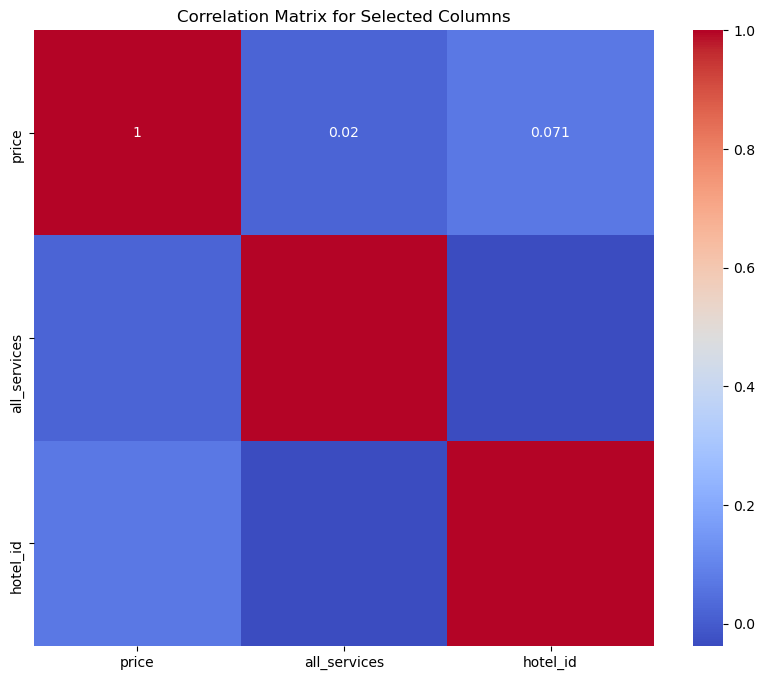

In [12]:
selected_columns = ['price', 'all_services','hotel_id']
selected_data = data[selected_columns]
correlation_matrix = selected_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Selected Columns')
plt.show()


## feature importance - according to the code itself

C:\Users\ygastfraind\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


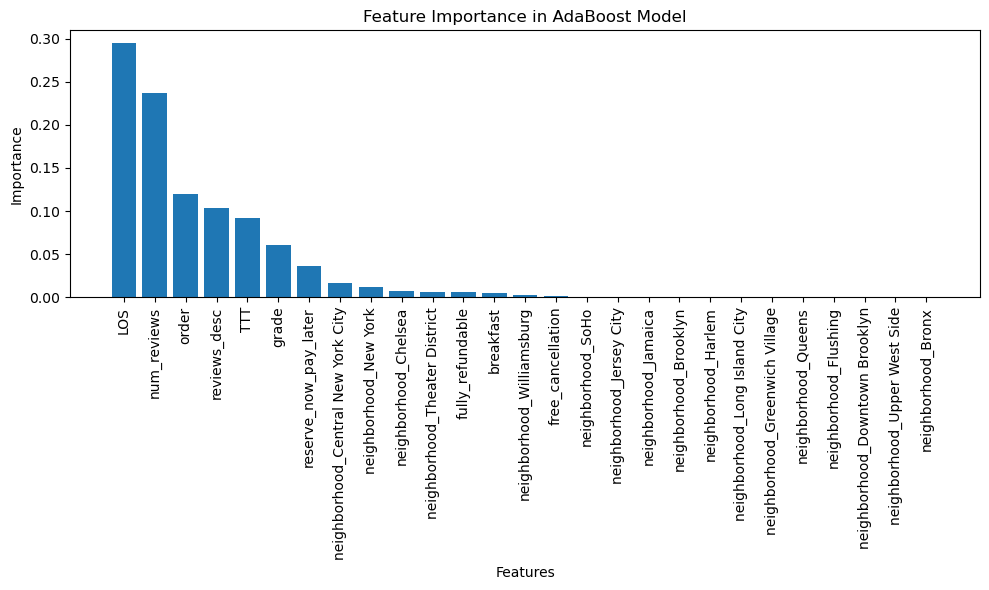

                               feature    importance
8                                  LOS  2.951568e-01
1                          num_reviews  2.372967e-01
9                                order  1.194934e-01
0                         reviews_desc  1.035926e-01
7                                  TTT  9.174146e-02
4                                grade  6.065690e-02
6                reserve_now_pay_later  3.623997e-02
12  neighborhood_Central New York City  1.582650e-02
21               neighborhood_New York  1.184114e-02
13                neighborhood_Chelsea  6.660016e-03
24       neighborhood_Theater District  5.939903e-03
5                     fully_refundable  5.471040e-03
2                            breakfast  5.264785e-03
26           neighborhood_Williamsburg  2.585575e-03
3                    free_cancellation  1.690991e-03
23                   neighborhood_SoHo  5.164556e-04
19            neighborhood_Jersey City  2.567515e-05
18                neighborhood_Jamaica  7.0960

In [13]:
best_n_estimators = 200
best_model = AdaBoostRegressor(
    base_estimator=DecisionTreeRegressor(max_depth=4),
    n_estimators=best_n_estimators,
    random_state=42
)
best_model.fit(X_train, y_train)

# Calculate the importance of features
feature_importance = best_model.feature_importances_

# Create a DataFrame with the feature names and their importance
feature_names = X.columns
importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})

importance_df = importance_df.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(importance_df['feature'], importance_df['importance'])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance in AdaBoost Model')
plt.tight_layout()
plt.show()

print(importance_df)

## feature importance 

                               feature  importance
8                                  LOS    1.818908
4                                grade    0.019941
0                         reviews_desc    0.015560
9                                order    0.015114
1                          num_reviews    0.009481
7                                  TTT    0.008099
21               neighborhood_New York    0.002224
6                reserve_now_pay_later    0.001224
12  neighborhood_Central New York City    0.000816
2                            breakfast    0.000728
13                neighborhood_Chelsea    0.000307
26           neighborhood_Williamsburg    0.000238
5                     fully_refundable    0.000146
24       neighborhood_Theater District    0.000028
3                    free_cancellation    0.000023
23                   neighborhood_SoHo    0.000009
19            neighborhood_Jersey City    0.000009
11               neighborhood_Brooklyn    0.000000
10                  neighborhoo

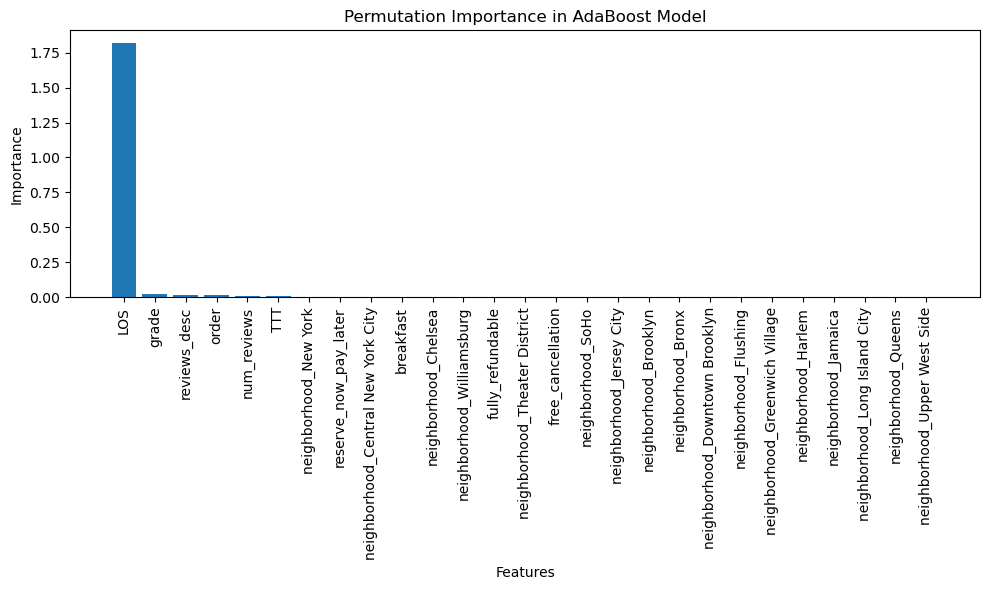

In [14]:
from sklearn.inspection import permutation_importance


# Calculating the importance of features using Permutation Importance
perm_importance = permutation_importance(best_model, X_test, y_test, n_repeats=5, random_state=42)

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': perm_importance.importances_mean
}).sort_values(by='importance', ascending=False)

print(feature_importance_df)

plt.figure(figsize=(10, 6))
plt.bar(feature_importance_df['feature'], feature_importance_df['importance'])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Permutation Importance in AdaBoost Model')
plt.tight_layout()
plt.show()

